# Predicting Future Sales

In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import datetime # manipulating date formats
import statsmodels.api as sm
# Loading visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from itertools import product
from sklearn.preprocessing import LabelEncoder

import time
import sys
import gc
import pickle
sys.version_info

# import sys
# !conda install --yes --prefix {sys.prefix} lux-api
# import lux

# Formating the code
import warnings
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/sales_train.csv
./data/shops.csv
./data/test.csv
./data/submission.csv
./data/item_categories.csv
./data/items.csv
./data/sample_submission.csv


In [12]:
# reading data

items = pd.read_csv('./data/items.csv')
cats = pd.read_csv('./data/item_categories.csv')
train = pd.read_csv('./data/sales_train.csv')
shops = pd.read_csv('./data/shops.csv')
test = pd.read_csv('./data/test.csv')

In [13]:
display(test.head())
display(train.head())

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [14]:

shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code', 'shop_name', 'city']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [15]:
#Define a function that shows some info about a dataset 
def get_info(df):
    #show some infos about the dataframe
    print('+++++++++++++++++++++++++++++')
    print(f'HEAD :',end='\n')
    print(df.head())
    print('+++++++++++++++++++++++++++++')
    print(f'INFOS :',end='\n')
    print(df.info())
    print('+++++++++++++++++++++++++++++')
    print(f'STATS :',end='\n')
    print(df.describe().transpose())
    print('+++++++++++++++++++++++++++++')
    print('Number of Null Values :',end=' ')
    print(df.isnull().sum().sum())
    print('+++++++++++++++++++++++++++++')
    print(f'SHAPE :',end=' ')
    print(df.shape)
    
# credit: https://www.kaggle.com/hankarmostafa/forecasting-future-sales-using-lstm

In [16]:
get_info(train)

display(items.describe().T)
display(cats.describe().T)
display(train.describe().T)
display(train.shape)
display(test.shape)

display(shops.columns)
display(cats.columns)
display(train.columns)
display(items.columns)
display(test.columns)

+++++++++++++++++++++++++++++
HEAD :
         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
+++++++++++++++++++++++++++++
INFOS :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB
None
+++++++++++++++++++++++++++++
STATS :
                    count     

,count,mean,std,min,25%,50%,75%,max
item_id,22170.0,11084.500000,6400.072070,0.0,5542.25,11084.5,16626.75,22169.0
item_category_id,22170.0,46.290753,15.941486,0.0,37.00,40.0,58.00,83.0


,count,mean,std,min,25%,50%,75%,max
item_category_id,84.0,41.500000,24.392622,0.0,20.75,41.5,62.25,83.0
type_code,84.0,9.619048,4.933057,0.0,5.00,11.5,14.00,19.0
subtype_code,84.0,29.107143,19.592855,0.0,12.75,25.5,46.25,64.0


,count,mean,std,min,25%,50%,75%,max
date_block_num,2935849.0,14.569911,9.422988,0.0,7.0,14.0,23.0,33.0
shop_id,2935849.0,33.001728,16.226973,0.0,22.0,31.0,47.0,59.0
item_id,2935849.0,10197.227057,6324.297354,0.0,4476.0,9343.0,15684.0,22169.0
item_price,2935849.0,890.853233,1729.799631,-1.0,249.0,399.0,999.0,307980.0
item_cnt_day,2935849.0,1.242641,2.618834,-22.0,1.0,1.0,1.0,2169.0


(2935849, 6)

(214200, 3)

Index(['shop_id', 'city_code', 'shop_name', 'city'], dtype='object')

Index(['item_category_id', 'type_code', 'subtype_code'], dtype='object')

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

Index(['item_id', 'item_category_id'], dtype='object')

Index(['ID', 'shop_id', 'item_id'], dtype='object')

In [17]:
#get some informations on our datasets 
print ('# of shops: ', train['shop_id'].max())
print ('# of items: ', train['item_id'].max())
print ('# of months: ',train['date_block_num'].max())
print ('# of categories: ', items['item_category_id'].max())

# credit: https://www.kaggle.com/hankarmostafa/forecasting-future-sales-using-lstm

# of shops:  59
# of items:  22169
# of months:  33
# of categories:  83


In [18]:
# join datasets

df = train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(cats, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)


df.date = df.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

df['revenue'] = df['item_cnt_day'] * df['item_price']

df['year'] = df['date_block_num'].apply(lambda x: ((x//12) + 2013))
df['month'] = df['date_block_num'].apply(lambda x: (x %12) + 1 )

display(df.shape) # 10 columns, 2.9M records
df.head()

(2935849, 15)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_code,shop_name,city,type_code,subtype_code,revenue,year,month
0,2013-01-02,0,59,22154,999.00,1.0,37,30,"Ярославль ТЦ ""Альтаир""",Ярославль,11,1,999.00,2013,1
1,2013-01-03,0,25,2552,899.00,1.0,58,13,"Москва ТРК ""Атриум""",Москва,13,27,899.00,2013,1
2,2013-01-05,0,25,2552,899.00,-1.0,58,13,"Москва ТРК ""Атриум""",Москва,13,27,-899.00,2013,1
3,2013-01-06,0,25,2554,1709.05,1.0,58,13,"Москва ТРК ""Атриум""",Москва,13,27,1709.05,2013,1
4,2013-01-15,0,25,2555,1099.00,1.0,56,13,"Москва ТРК ""Атриум""",Москва,13,3,1099.00,2013,1


Text(0.5, 1.0, 'Monthly Revenue')

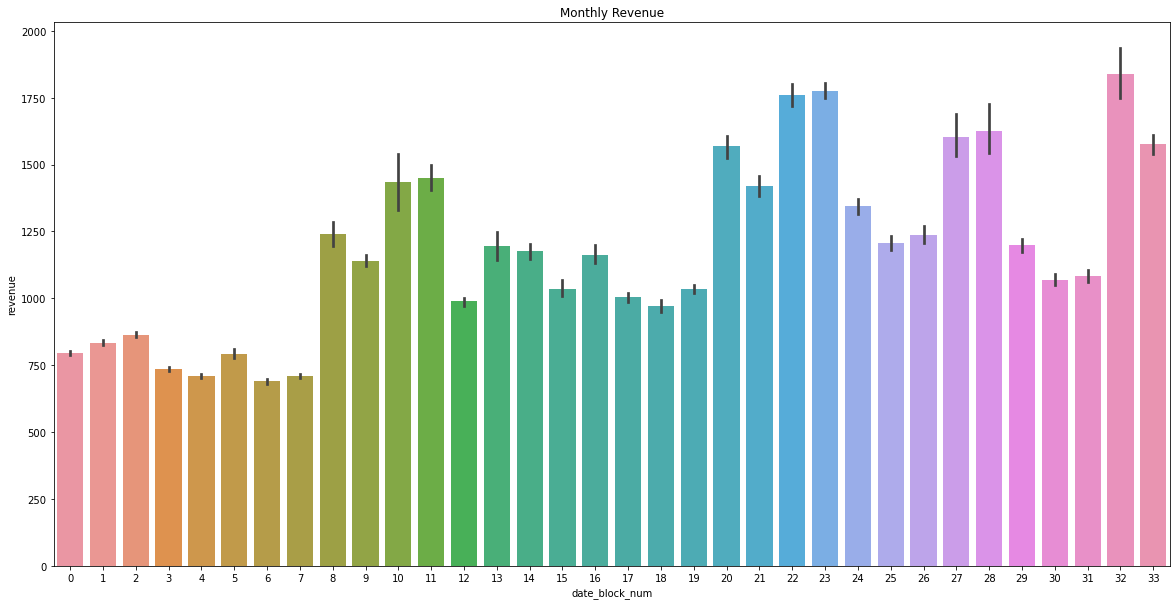

In [19]:
plt.figure(figsize=(20,10))
sns.barplot(x=df.date_block_num, y=df.revenue).set_title('Monthly Revenue')

# Regression with scikit-learn

## Training Data Pre-Processing

https://www.kaggle.com/fotiskamanis/predict-sales-by-encoding-categories

In [20]:
train_cols1 = ['shop_id', 'item_id', 'item_category_id', 'item_mean_price']
train_cols2 = [f'{i}' for i in range(1,35)]
train_cols = train_cols1 + train_cols2

In [21]:
# Get mean sales price per item and rename aggregate column to item_mean_price
agg_item_price = {'item_price':'item_mean_price'}
df_prices = train.groupby('item_id').agg({'item_price':'mean'}).rename(columns=agg_item_price)
print(df_prices.shape)
df_prices.head()

(21807, 1)


,item_mean_price
item_id,
0,58.0
1,4490.0
2,58.0
3,79.0
4,58.0


In [22]:
# Merge sales with item categories
df_sales = pd.merge(train, items, on='item_id', how='left')

# Drop columns date_block_num, item_price, and item_name
df_sales.drop(['date_block_num', 'item_price'], axis=1, inplace=True)

# Convert date column to YYYY-MM
df_sales['date'] = pd.to_datetime(df_sales['date'], dayfirst=True)
df_sales['date'] = df_sales['date'].apply(lambda x: x.strftime('%Y-%m'))


print(df_sales.shape)
df_sales.head()

(2935849, 5)


,date,shop_id,item_id,item_cnt_day,item_category_id
0,2013-01,59,22154,1.0,37
1,2013-01,25,2552,1.0,58
2,2013-01,25,2552,-1.0,58
3,2013-01,25,2554,1.0,58
4,2013-01,25,2555,1.0,56


In [23]:
# Merge sales with item prices (mean price per item)
df_sales = pd.merge(df_sales, df_prices, on='item_id', how='left')
print(df_sales.shape)
df_sales.head()

(2935849, 6)


,date,shop_id,item_id,item_cnt_day,item_category_id,item_mean_price
0,2013-01,59,22154,1.0,37,702.932203
1,2013-01,25,2552,1.0,58,937.888889
2,2013-01,25,2552,-1.0,58,937.888889
3,2013-01,25,2554,1.0,58,1709.050000
4,2013-01,25,2555,1.0,56,1123.101786


In [24]:
# Get sum value for item_cnt_day and rename column to item_sum_qty 
agg_item_cnt = {'item_cnt_day':'item_sum_qty'}

df_sales = df_sales.groupby(['date', 'shop_id', 'item_id', 'item_category_id', 'item_mean_price']).agg({'item_cnt_day':'sum'}).rename(columns=agg_item_cnt)
print(df_sales.shape)
df_sales.head()

(1609124, 1)


item_sum_qty
date    shop_id item_id item_category_id item_mean_price              
2013-01 0       32      40               249.629240                6.0
                33      37               252.831928                3.0
                35      40               375.828056                1.0
                43      40               167.222222                1.0
                51      57               265.708333                2.0

In [25]:
# Create train dataframe from sales by converting date rows to columns (to be used as features) 
df_train = df_sales.pivot_table(index=['shop_id', 'item_id', 'item_category_id', 'item_mean_price'], columns='date', values='item_sum_qty', fill_value=0)
df_train.reset_index(inplace=True)

display(df_train.head())

df_train.columns = train_cols

print(df_train.shape)
display(df_train.head())

date,shop_id,item_id,item_category_id,item_mean_price,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,30,40,323.679206,0,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,37,578.630005,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,40,249.629240,6,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,37,252.831928,3,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,40,375.828056,1,14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(424124, 38)


,shop_id,item_id,item_category_id,item_mean_price,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,34
0,0,30,40,323.679206,0,31,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,31,37,578.630005,0,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,32,40,249.629240,6,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,33,37,252.831928,3,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,35,40,375.828056,1,14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Declare features and prediction target for train data
X_train = df_train.drop(['34'], axis = 1)
Y_train = df_train['34'].values
print(X_train.shape, Y_train.shape)

(424124, 37) (424124,)


# Pre-Processing Sales Test Data

In [27]:
#merge the train set and the test set 
df_test = pd.merge(test, df_train, on=['item_id', 'shop_id'], how='left')

# Drop columns to match the features of train dataframe and fill na values with 0
df_test.drop(['ID', '1'], axis=1, inplace=True)
df_test = df_test.fillna(0)
df_test.head()

,shop_id,item_id,item_category_id,item_mean_price,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
0,5,5037,19.0,1926.828388,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,800.777500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,23.0,790.512923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# Rename test dataframe columns to match those of train dataframe
df_test_cols1 = ['shop_id', 'item_id', 'item_category_id', 'item_mean_price']
df_test_cols2 = [f'{i}' for i in range(1,34)]
df_test_cols = df_test_cols1 + df_test_cols2
df_test.columns = df_test_cols
print(df_test.shape)
df_test.head()

(214200, 37)


,shop_id,item_id,item_category_id,item_mean_price,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,5,5037,19.0,1926.828388,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,5,5320,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5,5233,19.0,800.777500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,5,5232,23.0,790.512923,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,5268,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Declare features for test data
X_test = df_test
print(X_test.shape)

(214200, 37)


# Pipeline Dev

In [30]:
# Set column transformer for encoding column item_category_id
column_trans = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), ['item_category_id']), remainder='passthrough')

In [31]:
# Select model
rfr = RandomForestRegressor(n_estimators = 100)

In [32]:
# Create pipeline
pipeline = make_pipeline(column_trans, rfr)

In [33]:
# Split data
x_train, x_train_test, y_train, y_train_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=21)
print('Train set:', x_train.shape,  y_train.shape)
print('Test set:', x_train_test.shape,  y_train_test.shape)

Train set: (339299, 37) (339299,)
Test set: (84825, 37) (84825,)


In [34]:
# Fit pipeline
%time pipeline.fit(x_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['item_category_id'])])),
                ('randomforestregressor', RandomForestRegressor())])

In [35]:
# Evaluate pipeline
print('Train set mse:', mean_squared_error(y_train, pipeline.predict(x_train)))
print('Test set mse:', mean_squared_error(y_train_test, pipeline.predict(x_train_test)))
print('Test set score:', pipeline.score(x_train, y_train))

Train set mse: 2.6861304778381307
Test set mse: 1.8125972661361631
Test set score: 0.8619930105551898


### Model Persistence
Serialize model object using pickle

In [43]:
# Save pipeline fit object
from joblib import dump, load
dump(pipeline, './pipeline.joblib')

['./pipeline.joblib']

In [ ]:
# Load a saved pipeline object
# pipeline = load('pipeline.joblib')

In [47]:
# Saving the model data:
with open('./model_data.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([x_train, x_train_test, y_train, y_train_test], f)

In [49]:
# Loading back the model data:
with open('./model_data.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    x_train, x_train_test, y_train, y_train_test = pickle.load(f)

# Model Development & Evaluation

In [36]:
# Linear regression
lr = LinearRegression()
lr.fit(x_train, y_train)
print('Train set mse:', mean_squared_error(y_train, lr.predict(x_train)))
print('Test set mse:', mean_squared_error(y_train_test, lr.predict(x_train_test)))
print('Test set score:', lr.score(x_train, y_train))

Train set mse: 10.804000338358241
Test set mse: 6.950459410216411
Test set score: 0.44491618223342966


In [37]:
# Random forest regression
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(x_train, y_train)
print('Train set mse:', mean_squared_error(y_train, rfr.predict(x_train)))
print('Test set mse:', mean_squared_error(y_train_test, rfr.predict(x_train_test)))
print('Test set score:', rfr.score(x_train, y_train))

Train set mse: 2.5365117011839122
Test set mse: 2.0594709036251113
Test set score: 0.8696800671225545


# Prediction

In [38]:
# Predict with pipeline
prediction = pipeline.predict(X_test)

In [39]:
# Prepare predictions
prediction = prediction.clip(0, 20)

In [40]:
# Check predictions
print(prediction.shape)
prediction

(214200,)


array([0.38, 4.32, 0.54, ..., 0.05, 9.6 , 0.11])

# Submission

In [41]:
df_submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
print(df_submission.shape)
df_submission.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv'

In [ ]:
df_submission['item_cnt_month'] = prediction
df_submission.to_csv('submission.csv', index=False)

## Permutation Importance
https://scikit-learn.org/stable/modules/permutation_importance.html

Its validation performance, measured via the 
 score, is significantly larger than the chance level. This makes it possible to use the permutation_importance function to probe which features are most predictive:

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(rfr, x_train, y_train, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{diabetes.feature_names[i]:<8}"
            f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

# Save Environment & Test / Train Datasets